In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, GlobalMaxPool1D, Reshape, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import Constant
import tensorflow as tf
import spacy
import matplotlib.pyplot as plt

In [2]:
!pip install wandb -qqq
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
from wandb.integration.keras import WandbCallback

The pretrained spacy model, I guess.

In [4]:
!python -m spacy download pl_core_news_md
import pl_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 MB 9.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


###GitHub
We'll be retrieving training and test data directly from GitHub.

In [5]:
!wget https://github.com/Aszanat/2024-emotion-recognition-v2/raw/main/train/in.tsv
!wget https://github.com/Aszanat/2024-emotion-recognition-v2/raw/main/train/expected.tsv

input = pd.read_csv('in.tsv', sep='\t').dropna()
output = pd.read_csv('expected.tsv', sep='\t').dropna()

--2024-07-04 14:40:29--  https://github.com/Aszanat/2024-emotion-recognition-v2/raw/main/train/in.tsv
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Aszanat/2024-emotion-recognition-v2/main/train/in.tsv [following]
--2024-07-04 14:40:29--  https://raw.githubusercontent.com/Aszanat/2024-emotion-recognition-v2/main/train/in.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839457 (820K) [text/plain]
Saving to: ‘in.tsv’

in.tsv              100%[===================>] 819.78K  --.-KB/s    in 0.03s   

2024-07-04 14:40:30 (26.4 MB/s) - ‘in.tsv’ saved [839457/839457]

--2024-07-04 14:40:30--  https

#Preprocessing
Divides the table with sentences and ###s to separate opinions in an array.

In [6]:
def divide_opinions(table):
    opinions = []
    sentences = []
    for i, j in table.iterrows():
      if (j.get('text') == '###########################'):
        opinions.append(sentences)
        sentences = []
      else:
        sentences.append(j.get('text'))
    return opinions


In [7]:
opinions = divide_opinions(input)

#Actual input for neural network
Input: two pairs of string series, since I can't get anything else to work.

Output: an array of vectors in which 1 means True and 0 means False.

In [8]:
def opinions_to_series(opinions):
  # opinions is a list of (list of sentences)
  context = []
  text = []
  for o in opinions:
    review = ''.join(o)
    for s in o:
      context.append(review)
      text.append(s)
    context.append(review)
    text.append(review) # the whole review has its own sentiment too
  # np_context = np.array(context)
  # np_text = np.array(text)
  # return (pd.Series(np_context), pd.Series(np_text))
  return (context, text)

In [9]:
context, text = opinions_to_series(opinions)

In [10]:
def labels_to_vectors(label_table):
  lab_vecs = []
  for i, j in label_table.iterrows():
    lab_vec = []
    for value in j.array:
      if (value):
        lab_vec.append(1)
      else:
        lab_vec.append(0)
    lab_vecs.append(lab_vec)
  return np.array(lab_vecs)

In [11]:
labels_vec = labels_to_vectors(output)
print(labels_vec)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]]


#Network
Let's build that thing!

In [12]:
nlp = pl_core_news_md.load()

In [13]:
max_tokens = 20000 # "random" number, we'll see how it works
Vectorizer = TextVectorization(max_tokens=max_tokens, output_mode='int')
Vectorizer.adapt(input.text.to_numpy())
vocab = Vectorizer.get_vocabulary()

In [14]:
context_seq = Vectorizer(context)
sentence_seq = Vectorizer(text)

In [15]:
num_tokens = len(vocab)
embedding_dim = len(nlp('to').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(str(word)).vector

In [16]:
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    # trainable=False
    )

In [26]:
input_context = Input(shape=(None,), dtype='int64', name='input_context')
input_sentence = Input(shape=(None,), dtype='int64', name='input_sentence')

embedding_layer = Embedding(input_dim=max_tokens, output_dim=100) # delete this line!

embedded_context = Embedding_layer(input_context)
embedded_sentence = Embedding_layer(input_sentence)

lstm_context = LSTM(64)(embedded_context)
lstm_sentence = LSTM(64)(embedded_sentence)

drop_context = Dropout(0.5)(lstm_context)
drop_sentence = Dropout(0.5)(lstm_sentence)

gmp_context = Dense(32, activation='tanh',
                kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop_context)
gmp_sentence = Dense(32, activation='tanh',
                kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop_sentence)

concatenated = concatenate([gmp_context, gmp_sentence])

drop_concat = Dropout(0.5)(concatenated)

dense_concat = Dense(32, activation='tanh',
                kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop_concat)

output = Dense(11, activation='sigmoid')(dense_concat)  # Adjust output shape based on your task

model = Model(inputs=[input_context, input_sentence], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_context (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 input_sentence (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 embedding (Embedding)       (None, None, 300)            6000000   ['input_context[0][0]',       
                                                                     'input_sentence[0][0]']      
                                                                                            

In [27]:
lr = .02
epochs = 10

In [28]:
wandb.init(
project="EmotionRecognition",
name=f"with_fixed_embeddings_lr_{lr}",
config={
  "learning_rate": lr,
  "architecture": "MLP",
  "dataset": "Children texts",
  "epochs": epochs})

config = wandb.config
logging_callback = WandbCallback(log_evaluation=True)

accuracy,█▅▃▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,███████▁▁▁
val_loss,▇▆▁█▆▁▄▄▄▂
accuracy,0.01046
best_epoch,2
best_val_loss,0.51799
epoch,9
loss,0.51085
val_accuracy,0.00697


In [ ]:
history = model.fit({'input_context': context_seq, 'input_sentence': sentence_seq},
                    labels_vec,
                    epochs=epochs,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[logging_callback])


wandb: WARNING WandbCallback is unable to read validation_data from trainer and therefore cannot log validation data. Ensure Keras is properly patched by calling `from wandb.keras import WandbCallback` at the top of your script.


Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.1412

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240704_151240-x0i3lfwe/files/model-best)... Done. 10.8s


180/180 [==============================] - 150s 810ms/step - loss: 0.5482 - accuracy: 0.1412 - val_loss: 0.5396 - val_accuracy: 0.0063
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.0678

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240704_151240-x0i3lfwe/files/model-best)... Done. 31.5s


180/180 [==============================] - 136s 759ms/step - loss: 0.5280 - accuracy: 0.0678 - val_loss: 0.5300 - val_accuracy: 0.0063
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.0467

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240704_151240-x0i3lfwe/files/model-best)... Done. 15.8s


180/180 [==============================] - 115s 641ms/step - loss: 0.5242 - accuracy: 0.0467 - val_loss: 0.5294 - val_accuracy: 0.0063
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.0326

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240704_151240-x0i3lfwe/files/model-best)... Done. 15.6s


180/180 [==============================] - 122s 679ms/step - loss: 0.5216 - accuracy: 0.0326 - val_loss: 0.5294 - val_accuracy: 0.0063
Epoch 5/10
180/180 [==============================] - 36s 198ms/step - loss: 0.5191 - accuracy: 0.0239 - val_loss: 0.5312 - val_accuracy: 0.0063
Epoch 6/10
180/180 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.0185

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240704_151240-x0i3lfwe/files/model-best)... Done. 11.6s


180/180 [==============================] - 134s 749ms/step - loss: 0.5172 - accuracy: 0.0185 - val_loss: 0.5242 - val_accuracy: 0.0063
Epoch 7/10
180/180 [==============================] - 34s 186ms/step - loss: 0.5160 - accuracy: 0.0131 - val_loss: 0.5298 - val_accuracy: 0.0021
Epoch 8/10
180/180 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.0187

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240704_151240-x0i3lfwe/files/model-best)... Done. 16.9s


180/180 [==============================] - 107s 595ms/step - loss: 0.5145 - accuracy: 0.0187 - val_loss: 0.5227 - val_accuracy: 0.0063
Epoch 9/10
180/180 [==============================] - 32s 177ms/step - loss: 0.5136 - accuracy: 0.0153 - val_loss: 0.5358 - val_accuracy: 0.0021
Epoch 10/10
180/180 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.0120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240704_151240-x0i3lfwe/files/model-best)... Done. 24.3s


In [21]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

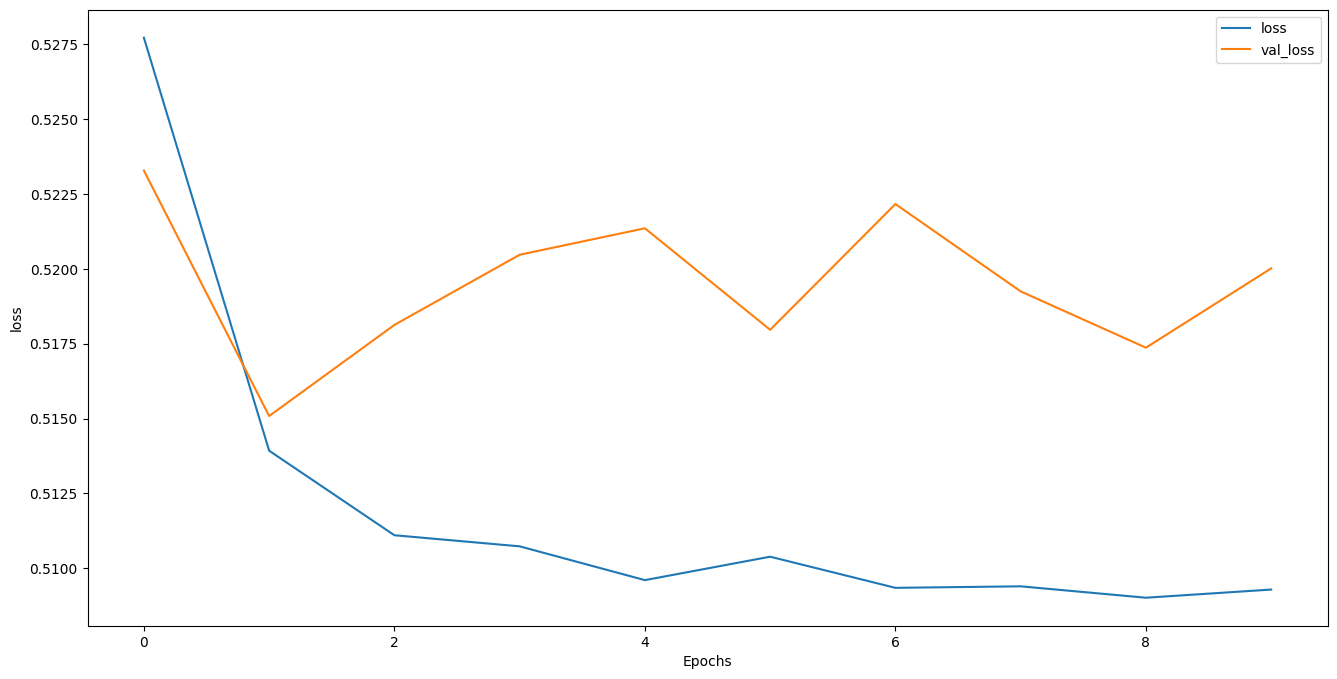

In [22]:
plt.figure(figsize=(16, 8))
plot_graphs(history, 'loss')